In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
hallmark = pd.read_excel('/ihome/hosmanbeyoglu/kor11/tools/CITRUS/FW__MCF10A_wild_type_and_PIK3CA_H1047R_knock-in_cell_lines/Supplementary Table S4.xlsx', 
    sheet_name='MCF10A_hallmark_PI3K_Inhibition')

In [3]:
from utils import Data, get_ppi_edge_list

data_csv = Data(
    fGEP_SGA = 'data/CITRUS_GEP_SGAseparated.csv',
    fgene_tf_SGA = 'data/CITRUS_gene_tf_SGAseparated.csv',
    fcancerType_SGA = 'data/CITRUS_canType_SGAseparated.csv',
    fSGA_SGA = 'data/CITRUS_SGA_SGAseparated.csv',
)

In [4]:
ppi = pd.DataFrame(get_ppi_edge_list(sparse=False)[:, :2], columns=['A', 'B'])

(utils.py : 457) -    DEBUG | Loaded 352251 edges from the SIGNOR and SNAP Networks


In [5]:
# tf_ppi = ppi[ppi.A.isin(data_csv.tf) | ppi.B.isin(data_csv.tf)]
# tfs = pd.DataFrame(data_csv.tf)
# tfs.columns = ['tf']
# tfs['interacts_with'] = tfs.tf.apply(lambda x: set(tf_ppi[(tf_ppi==x).any(axis=1)].values.reshape(-1)))
# tfs = dict(zip(tfs['tf'], tfs['interacts_with']))
# def does_interact(tf, geneset):
#     if tf in geneset or len(tfs.get(tf, set()).intersection(geneset)) > 0:
#         return True            
#     return False

In [6]:
# pbar = tqdm(total=len(hallmark.values))
# hallmark_mask = np.zeros((hallmark.shape[0], len(data_csv.tf)), dtype=int)

# for idx, (pathway, genes) in enumerate(hallmark.values):
#     for idy, tf in enumerate(data_csv.tf):
#         pbar.set_description(f'{pathway[9:]} | ({idy}/{len(data_csv.tf)}) - {tf}')
#         if does_interact(tf, genes.split('/')):
#             hallmark_mask[idx, idy] = 1
    
#     pbar.update(1)
# pbar.close()

# np.save('hallmark_mask.npy', hallmark_mask)

In [7]:
hallmark_mask = np.load('hallmark_mask.npy')

In [8]:
import os
import argparse
from utils import bool_ext, load_dataset, split_dataset, evaluate, checkCorrelations
from models import CITRUS
import pickle
import torch
import numpy as np
import pandas as pd
import warnings 
from pathlib import Path
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore")
from sklearn import metrics

import yaml

with open('args.yaml', 'r') as f:
    args_dict = yaml.safe_load(f)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cuda':
    device_name = torch.cuda.get_device_name(0)
else:
    device_name = 'cpu'


parser = argparse.ArgumentParser()
args = argparse.Namespace(**args_dict)
args.tf_gene = np.load('tf_gene.npy')

In [36]:
dataset, dataset_test = load_dataset(
    input_dir=args.input_dir,
    mask01=args.mask01,
    dataset_name=args.dataset_name,
    gep_normalization=args.gep_normalization,
)

train_set, test_set = split_dataset(dataset, ratio=0.66)

daata = pickle.load( open("/ihome/hosmanbeyoglu/kor11/tools/CITRUS/data/dataset_CITRUS.pkl", "rb") )
cancers = daata['idx2can']


models = []
for m in tqdm(list(Path('./output').iterdir())):
    model = CITRUS(args) 
    model.build(device=device)
    model.to(device);
    try:
        model.load_state_dict(torch.load(m, map_location=torch.device('cpu')))
    except:
        checkpoint = torch.load(m, map_location=torch.device('cpu'))
        model.load_state_dict(checkpoint['state_dict'])
    model.eval()

    preds, tf, hid_tmr, tf, _, _  = model.forward(
                torch.tensor(test_set['sga']), 
                torch.from_numpy(test_set['can'])
            )
        
    genes_ = test_set['gep'].shape[1]
    test_df = pd.DataFrame(np.concatenate([test_set['gep'], 
                                            test_set['can'], 
                                            preds.detach().cpu().numpy()], axis=1))

    test_cancers = {}
    for ix, canc in cancers.items():
        test_cancers[canc] =  {}
        test_cancers[canc]['test'] = test_df[test_df[genes_]==ix+1].values[:, :genes_]    
        test_cancers[canc]['pred'] = test_df[test_df[genes_]==ix+1].values[:, genes_+1:] 
        
    o = ['BLCA', 'BRCA', 'CESC', 'COAD', 
        'ESCA', 'GBM', 'HNSC', 'KIRC', 
        'KIRP', 'LIHC', 'LUAD', 'LUSC', 
        'PCPG', 'PRAD', 'STAD', 'THCA', 
        'UCEC']

    _corrs = []
    _mses = []
    for canc in o:
            corr = checkCorrelations(test_cancers[canc]['test'], test_cancers[canc]['pred'], return_value=True)
            mse = metrics.mean_squared_error(test_cancers[canc]['test'], test_cancers[canc]['pred'])
            
            _corrs.append(corr)
            _mses.append(mse)
            
    model.performance = np.column_stack([_corrs, _mses])
    model.cancers = o
    
    if model.my_pvals() > 0.3 and model.performance[:, 0].mean() > 0.8:
        models.append(model)

    # model.save_model(os.path.join(args.output_dir, m.name))

  0%|          | 0/13 [00:00<?, ?it/s]

In [37]:
[m.performance for m in models]

[array([[0.88500166, 0.21723817],
        [0.9088142 , 0.17230479],
        [0.89025159, 0.20829177],
        [0.9180949 , 0.16084542],
        [0.89496428, 0.20140234],
        [0.87769788, 0.22985205],
        [0.90883987, 0.17560549],
        [0.91671222, 0.16264574],
        [0.89982433, 0.1916358 ],
        [0.89209282, 0.20712904],
        [0.90350115, 0.1839169 ],
        [0.90486963, 0.18138063],
        [0.85772384, 0.26870851],
        [0.93815202, 0.12384202],
        [0.90208831, 0.19048638],
        [0.91570582, 0.16329574],
        [0.88213537, 0.22326225]]),
 array([[0.88345781, 0.22032512],
        [0.90890721, 0.17235389],
        [0.88912574, 0.21072511],
        [0.9179067 , 0.16177532],
        [0.896419  , 0.19971671],
        [0.87048997, 0.24112187],
        [0.90742009, 0.17860153],
        [0.91449219, 0.16575637],
        [0.89877861, 0.19478209],
        [0.89263518, 0.20520056],
        [0.90233168, 0.1854326 ],
        [0.90652395, 0.1783457 ],
        [0.8

In [32]:
checkpoint = torch.load(m, map_location=torch.device('cpu'))

In [33]:
checkpoint

{'state_dict': OrderedDict([('layer_sga_emb.weight',
               tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
                       [-0.0015,  0.0031,  0.0028,  ...,  0.0031, -0.0041, -0.0042],
                       [-0.0074,  0.0042, -0.0045,  ..., -0.0043,  0.0013, -0.0031],
                       ...,
                       [-0.0017,  0.0023,  0.0006,  ...,  0.0092, -0.0037,  0.0006],
                       [-0.0011,  0.0025,  0.0034,  ..., -0.0087,  0.0001,  0.0044],
                       [ 0.0004,  0.0001,  0.0026,  ...,  0.0100, -0.0037, -0.0024]])),
              ('layer_can_emb.weight',
               tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
                       [-0.1145,  0.0846, -0.0173,  ...,  0.0548,  0.1046,  0.0716],
                       [ 0.1155, -0.0457, -0.0351,  ...,  0.0802, -0.0854, -0.1762],
                       ...,
                       [-0.0370, -0.0143, -0.0428,  ..., -0.0191, -0.0795, -0.0183],

In [ ]:
len(models)

6

In [16]:
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients
from scipy.stats import ttest_ind
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [17]:
wt = pd.read_parquet('wt.parquet')
sm_mut = pd.read_parquet('sm_mut.parquet')

In [18]:
R = None
S = None

for model in tqdm(models):
    model.eval()

    X = torch.from_numpy(model.sga)[model.idx]
    C = torch.from_numpy(model.can[model.idx])
    r = model(X, C, pathways=True).data.numpy()

    if R is None:
        R = r
    else:
        R += r

    X = torch.from_numpy(model.sga)[model.idy]
    C = torch.from_numpy(model.can[model.idy])
    s = model(X, C, pathways=True).data.numpy()

    if S is None:
        S = s
    else:
        S += s    

  0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
R.shape, S.shape

((351, 50), (198, 50))

In [20]:
R = R / len(models)
S = S / len(models)

In [21]:
p_predicted = pd.DataFrame(ttest_ind(R, S).pvalue, 
        index=hallmark.Description, 
        columns=['pvalue']).sort_values(by='pvalue', ascending=True).loc[hallmark.Description].pvalue.values

In [22]:
p_exp = hallmark['pvalue'].values

In [23]:
np.save('p_predicted.npy', p_predicted)
np.save('p_exp.npy', p_exp)

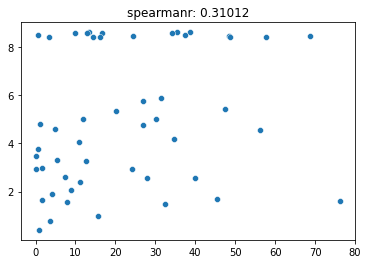

In [39]:
sns.scatterplot(-np.log(p_predicted), -np.log(p_exp))
plt.title(f'spearmanr: {spearmanr(p_predicted, p_exp).correlation:.5f}')
plt.show()

In [26]:
[m.pval_corr for m in models]

[0.31012293543249553]

In [27]:
len(models)

1

In [ ]:
# M = model
# M.analysis_mode = True
# lc = LayerConductance(M, M.pathways)

# results = []
# AA = []

# for frame, name in zip([wt, sm_mut, scna_mut, sm_scna_mut], ['WT', 'SM', 'SCNA', 'SM_SCNA']):
#     if len(frame) == 0:
#         break
#     scores = []

#     idx = xdf[xdf.id.isin(frame.index)].idx.values
#     X = torch.from_numpy(dataset['sga'])

#     # G = [i for i in data.gene_tf_sga.index if 'AKT' in i] + [i for i in data.gene_tf_sga.index if 'PIK' in i]
#     # G = ['PIK3CA']
#     # G = [i for i in data.gene_tf_sga.index if 'AKT' in i]
#     # G = [i for i in data.gene_tf_sga.index if 'PIK' in i]
    
#     # G = ['AKT1', 'PIK3CA', 'AKT2']
    
#     G = ['NFE2L2']
    
#     # G = merged2['PI3K/AKT Signaling in Cancer']
    
#     # G = ['AKT1']

#     for ix in tqdm([list(data.gep_sga.columns).index(g) for g in G if g in data.gep_sga.columns]):
#         a = lc.attribute((X[idx], torch.from_numpy(dataset['can'][idx])), n_steps=5, 
#                         attribute_to_layer_input=True, target=[ix]*len(X[idx]))
#         ig_attr_test_sum = a.detach().cpu().numpy().sum(0)
#         ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
#         scores.append(ig_attr_test_norm_sum)
        
#     AA.append(a)
#     g = np.array(_pathways[2])
#     at = np.sum(scores, 0)

#     assert g.shape == at.shape

#     df = pd.DataFrame([g, at]).T
#     df.columns = ['Pathways', f'score_{name}']
#     results.append(df.set_index('Pathways'))
    
# AA = np.array([i.detach().numpy() for i in AA])